# Tutorial: ML Tools and Techniques

This tutorial explores different tools and techniques for writting your own neural networks. We will cover the following topics:

1. ML overview
    * Types of machine learning: supervised vs unsupervised
    * Types of ML problems: regression vs classification 

2. Key concepts
    * Tensor as data representation
    * Data processing: train-test-split, dataset and dataloader.
    * DNN Layers: input, hidden, activation
    * Loss functions and back propagation.
    * Training and validation loop
    * Hyperparameters: layers, nodes, batch size, epochs, learning rate, ...
    * Performance: loss distribution, ROC curve, ...

3. Tools
    * Pytorch, Pytroch lightning
    * TensorFlow, Keras
    * scikit-learn

4. Example: supervised classification using pytorch

## ML Overview

### Types of machine learning

1. Supervised learning \
    -> Train model on **labeled** data \
    -> Model learns relationship between given inputs and labels
    -> Requires truth information for training (for us this means MC simulations)
2. Unsupervised learning \
    -> Train model on **unlabeled** data \
    -> Model learns to recognize patterns in inputs without specific context
    -> Can be trained on any dataset

In this example we will focus on a supervised learning problem. This is useful if you have a specific kind of signature you want to detect or variable you want to reconstruct. In the collider context that might mean identifying certain kinds of Higgs boson decays. Unsupervised learning is broadly useful for other types of problems where the signature we're looking for is less well defined (such as anomaly detection).

### Types of problems:

1. Regression \
    -> Labels have continuous values (i.e. jet mass, price of commodity, etc.)
2. Classification \
    -> Labels have discrete values (i.e. jet flavor, cats vs. dogs, etc.)

We will work through a classification example here. From a coding standpoint these two problems are not very different and we approach them in the same way (same neural network setup and training). The only thing that changes is the loss function (the quantity that our optimization is trying to minimize).

## Key concepts

### Tensor as data representation

**Quote**: A torch.Tensor is a multi-dimensional matrix containing elements of a single data type. \
In practice these are very similar to numpy arrays and have a more or less identical list of operations. However, tensors keep track of gradients during computations and can run on GPUs natively. Both of these features will turn out to be very useful in a machine learning context!

In [1]:
import torch
import numpy as np

In [2]:
# Define total number of samples

N1 = 5

# Generate a sample from a normal distribution using numpy.

arr = np.random.normal(0, 1, N1).astype(dtype=np.float32)

# Convert the numpy array to a pytorch tensor

t1 = torch.from_numpy(arr)

# Generate a sample using pytroch directly.

t2 = torch.randn(N1)

In [3]:
arr

array([ 0.49927607, -1.6757457 ,  0.69023097, -0.9071687 , -0.30411622],
      dtype=float32)

In [4]:
t1

tensor([ 0.4993, -1.6757,  0.6902, -0.9072, -0.3041])

In [5]:
t2

tensor([-0.4465,  1.6217, -0.7052,  1.3276,  1.0997])

In [6]:
t3 = torch.tensor(arr.astype(np.float32))
t3

tensor([ 0.4993, -1.6757,  0.6902, -0.9072, -0.3041])

In [7]:
# Repeat the above steps for a 2D gaussian and plot the samples

# Define total number of samples

N2 = 500

# Generate a sample from a normal distribution using numpy.

arr = np.random.normal(0, 1, (N2, 2)).astype(dtype=np.float32)

# Convert the numpy array to a pytorch tensor

t1 = torch.from_numpy(arr)

# Generate a sample using pytroch directly.

t2 = torch.randn((N2, 2))

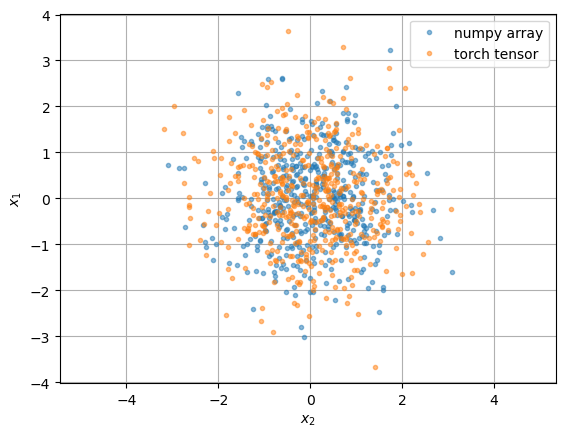

In [8]:
import matplotlib.pyplot as plt

plt.plot(arr[:, 0], arr[:, 1], '.', alpha=0.5, label="numpy array")
plt.plot(t2[:, 0], t2[:, 1], '.', alpha=0.5, label="torch tensor")
plt.axis('equal')
plt.ylabel(r"$x_1$")
plt.xlabel(r"$x_2$")
plt.grid()
plt.legend()
plt.show()

In practice, the dataset we use is stored as numpy arrays. We convert the dateset to tensors to be able to load them on the GPU. Note that when training on GPUs all relevant information needs to be moved there (i.e. model parameters, inputs, etc.)

In [12]:
# check with device our tensor is located on initially
t1.device

# check if GPU is available and copy tensor there
t1_gpu = torch.clone(t1)
if torch.cuda.is_available():
    t1_gpu = t1_gpu.to("cuda")
    
# check whether tensor was moved to GPU
t1_gpu.device

device(type='cpu')

In [13]:
def np_to_torch(arr):
    return torch.tensor(arr.astype(np.float32))

### Data processing: train-test-split, dataset and dataloader.

Let's first create a dataset with gaussian signal and background events.

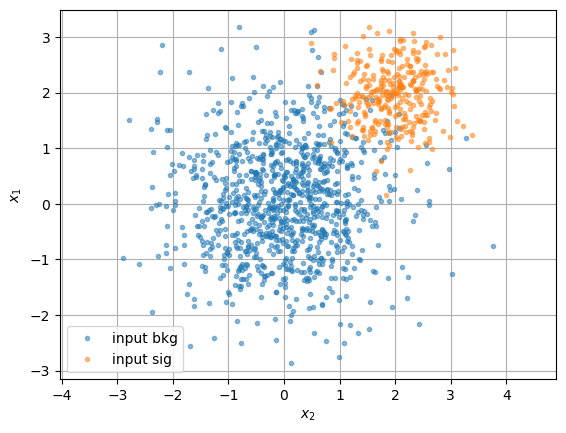

In [14]:
# First, create a dataset of gaussians using what we did above.

# Create an array called input_x which is the features of the traning set
# input_x consists of tow types of gaussians: input_bkg and input_sig

# input_bkg is 500 samples from a gaussian of N(0,1)
N_bkg = 1000
input_bkg = np.random.normal(0, 1, (N_bkg, 2)).astype(dtype=np.float32)

# input_sig is 500 samples from a gaussian of N(2,0.5)
N_sig = 300
input_sig = np.random.normal(2, 0.5, (N_sig, 2)).astype(dtype=np.float32)

# Plot input_x1 and input_x2
plt.plot(input_bkg[:, 0], input_bkg[:, 1], '.', alpha=0.5, label="input bkg")
plt.plot(input_sig[:, 0], input_sig[:, 1], '.', alpha=0.5, label="input sig")
plt.axis('equal')
plt.ylabel(r"$x_1$")
plt.xlabel(r"$x_2$")
plt.grid()
plt.legend()
plt.show()

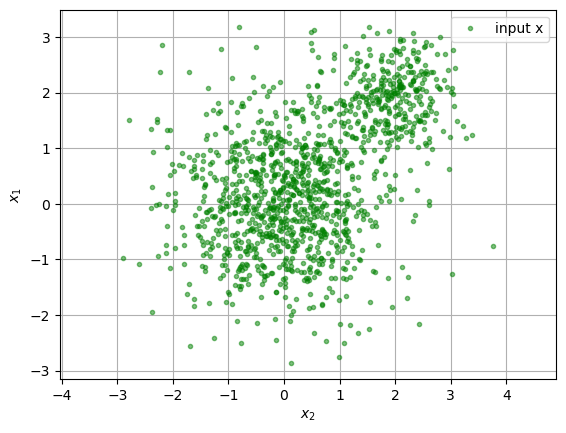

In [15]:
# create input_x which is a mixture of input_x1 and input_x2

input_x = np.concatenate([input_bkg, input_sig], axis=0)

# Plot input_x

plt.plot(input_x[:, 0], input_x[:, 1], '.', c="green", alpha=0.5, label="input x")
plt.axis('equal')
plt.ylabel(r"$x_1$")
plt.xlabel(r"$x_2$")
plt.grid()
plt.legend()
plt.show()

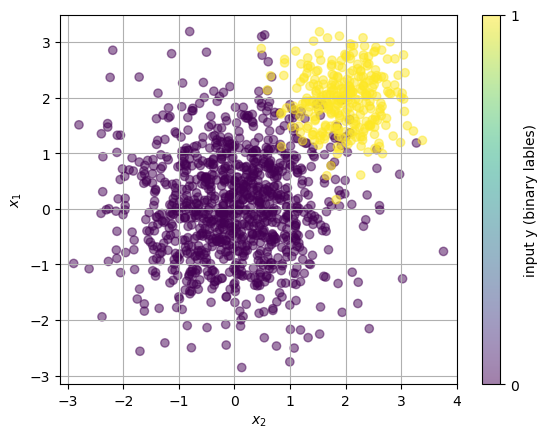

In [16]:
# create input_y which is the labels where input_x1 is labeled 0, and input_x2 is labeled 1

label_bkg = np.zeros(input_bkg.shape[0])  # Assign label 0 to input_x1
label_sig = np.ones(input_sig.shape[0])  # Assign label 1 to input_x2

input_y = np.concatenate([label_bkg, label_sig], axis=0).reshape(-1, 1)

# Plot input_y on the z-axis

sc = plt.scatter(input_x[:, 0], input_x[:, 1], c=input_y.flatten(), cmap='viridis', alpha=0.5)
plt.axis('equal')
plt.grid()
cbar = plt.colorbar(sc, ticks=[0, 1])  # Set the colorbar ticks to only show 0 and 1
cbar.set_label('input y (binary lables)')
plt.ylabel(r"$x_1$")
plt.xlabel(r"$x_2$")
plt.show()

Usually we train our ML models with a lot of data. The **TensorDataset** class allows us to define a coherent dataset without reading it into memory. We can then load it piecewise with a **DataLoader**. We are also able to integrate some preprocessing steps into these objects if desired (we won't do this here). The standard way to process data is to do the following:

1. Split the input dataset into training and validation sets.
2. Create TensorDataset for training and validation.
3. Create DataLoader for training and validation.

In [17]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [18]:
def process_data(input_x, input_y, batch_size):
    x_train, x_val, y_train, y_val = train_test_split(input_x, input_y, test_size=0.33, random_state=42)

    x_train = np_to_torch(x_train)
    y_train = np_to_torch(y_train)

    x_val = np_to_torch(x_val)
    y_val = np_to_torch(y_val)

    train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
    val_dataset = torch.utils.data.TensorDataset(x_val, y_val)

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_dataloader, val_dataloader

### DNN Layers: input, hidden, activation

**Input layer**: The first layer of a neural network containing its inputs.

**Hidden layers**: Intermediate layers between the input and output layer containing some "hidden" representation of the input data. This representation is built from linear combinations of the features in the preceeding layer followed by application of nonlinearities (activation functions).

**Activation function**: After each hidden layer, an activation function that defines how the weighted sum of the inputs is transformed into the output from a node in this layer of the network. Without these our neural network is entirely linear. A common activation function is `ReLU`, the Rectified Linear Unit function that returns 0 if it receives any negative input, and returns the same values for any positive input.

**Output layer**: The layer that generates the prediction of the network. In the case of a binary classifier, only 1 node is needed for the output layer. In the case of multiclass classification, multiple outputs, one for each class, is needed. The activation function used for the output layer of a binary classifer is the Sigmoid function (gives values between 0 and 1).

In [19]:
import torch.nn as nn

In [20]:
class Model(nn.Module):
    def __init__(self, layers, n_inputs, device="cpu"):
        # The constructor of a simple DNN model
        #
        # layers: a list of number of nodes in each layer.
        #         For example layers=[56, 56, 56] represents 3 layers with 56 nodes in each layer.
        #
        # n_inputs: the number of input features.
        #
        # device: cpu or gpu device.

        super().__init__()

        # Initialize the layes of the network

        layer_list = []

        # First, define input layer
        nodes = layers[0]
        layer_list.append(nn.Linear(n_inputs, nodes))
        layer_list.append(nn.ReLU())

        n_inputs = nodes

        # Next, add the hidden layers
        for nodes in layers[1:]:
            layer_list.append(nn.Linear(n_inputs, nodes))
            layer_list.append(nn.ReLU())
            n_inputs = nodes

        # Then, add the output layer
        layer_list.append(nn.Linear(n_inputs, 1))
        layer_list.append(nn.Sigmoid())

        # Lastly, stack the layers with the nn.Sequential() function
        self.model_stack = nn.Sequential(*layer_list)

        # Specify the device
        self.device = device

    def forward(self, x):
        return self.model_stack(x)

    def predict(self, x):
        with torch.no_grad():
            self.eval()
            x = torch.tensor(x, device=self.device)
            prediction = self.forward(x).detach().cpu().numpy()
        return prediction

### Loss function, forward-propagation, back-propagation, gradient descent.

**Loss function**: A mathematical function that quantifies the difference (loss) between predicted values (output) and target values (truth/labels) in some way. We want to minimize this during training. Commonly mean squared error for regression and cross-entropy for classification, but could be anything.

**Forward propagation**: The forward calculation of the network going from inputs to outputs (forward pass).

**Gradient descent**: The learning algorithm for multi-layer neural networks using the gradients of the loss function with respect to the model's parameters. Model parameters are adjusted in the direction which minimizes the loss function, thereby leading to better network predictions.

**Back-propagation**: The method for computing the gradient. Derivatives are computed layer by layer and propagated backwards via the chain rule.

In [26]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

from tqdm import tqdm
import os

In [23]:
# We use binary cross entropy loss for a binary classfier.

loss_func = F.binary_cross_entropy

### Training and validation loop

**Epochs**: An epoch represents a complete pass through the training set (i.e. the network has seen each event once). Standard neural network trainings will go over many epochs (dozens to hundreds).

**Batches**: During training, the network doesn't see the whole dataset at a time, but rather batches of it (i.e. some fraction). After each batch, backpropagation is performed and the model parameters are updated.

The total dateset is divided into training set, validation set, and test set.

**Training set**: The samples used to train the model. Gradient decent is performed on this dataset.

**Validation set**: The samples used to provide an unbiased evaluation of a model fit on the training dataset as the model parameters are being updated.

**Test set**: The samples used to evaluate the trained model.

In [27]:
# First, initialize a model

layers = [64, 64, 64]
n_inputs = 2
device = "cuda"

model = Model(layers=layers, n_inputs=n_inputs).to(device)

# Define loss funtion and optimizer
loss_func = F.binary_cross_entropy

# Creat an output directory

outdir = "./"
os.makedirs(outdir, exist_ok=True)

In [28]:
# Define traning paramaters
n_epochs = 100
batch_size = 256

learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [29]:
# Initialize training

update_epochs = 1

seed = 1
torch.manual_seed(seed)
np.random.seed(seed)

epochs, epochs_val = [], []
losses, losses_val = [], []

train_data, val_data = process_data(input_x, input_y, batch_size=batch_size)

100%|==========| 100/100 [00:02<00:00, 39.03it/s]


<function matplotlib.pyplot.show(close=None, block=None)>

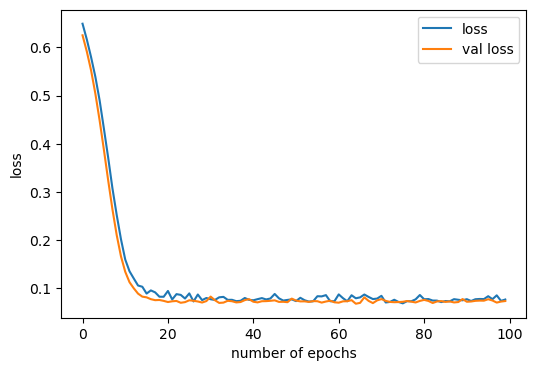

In [30]:
# Build a training loop

for epoch in tqdm(range(n_epochs), ascii=' >='):
    # Training

    losses_batch_per_e = []

    # set the mode to train
    model.train()

    for batch_ndx, data in enumerate(train_data):
        batch_inputs, batch_labels = data
        batch_inputs, batch_labels = batch_inputs.to(device), batch_labels.to(device)

        # (Re)set gradients of all model parameters to zero.
        optimizer.zero_grad()

        # Calculate the predicted outputs of this batch
        batch_outputs = model(batch_inputs)

        # Calculate the loss
        loss = loss_func(batch_outputs, batch_labels)

        # Save the loss
        losses_batch_per_e.append(loss.detach().cpu().numpy())
        mean_loss = np.mean(losses_batch_per_e)

        # Perform backpropagation.
        loss.backward()

        # Update the model parameters based on the gradients calculated during backpropagation.
        optimizer.step()

    epochs.append(epoch)
    losses.append(mean_loss)

    # Validation

    # No backpropagation, make it faster.
    with torch.no_grad():
        # set the mode to eval
        model.eval()
        val_losses_batch_per_e = []

        for batch_ndx, data in enumerate(val_data):
            batch_inputs, batch_labels = data
            batch_inputs, batch_labels = batch_inputs.to(device), batch_labels.to(device)

            batch_outputs = model(batch_inputs)
            val_loss = loss_func(batch_outputs, batch_labels)
            val_losses_batch_per_e.append(val_loss.detach().cpu().numpy())

        mean_val_loss = np.mean(val_losses_batch_per_e)
        losses_val.append(mean_val_loss)

        # print(f"Epoch: {epoch} - loss: {mean_loss} - val loss: {mean_val_loss}")


plt.figure(figsize=(6, 4))
plt.plot(epochs, losses, label="loss")
plt.plot(epochs, losses_val, label="val loss")
plt.xlabel("number of epochs")
plt.ylabel("loss")
plt.legend()
plt.show

**Note**

What's the difference between `zero_grad()` and `no_grad()`?


`zero_grad()` sets gradients of all model parameters to zero. This is the first setp of gradient decent.

`no_grad()` is a context-manager that disabled gradient calculation. Disabling gradient calculation is useful for inference, when you are sure that you will not call Tensor.backward(). It will reduce memory consumption for computations that would otherwise have `requires_grad=True`.


### Prediction: evaluate the trained model

**ROC curve and AUC**

- **ROC curve (receiver operating characteristic curve)**: a graph showing the performance of a classification model at all classification thresholds. 
- A ROC curve plots **two parameters**: 
    - **True Positive Rate (TPR)** $$ {\rm TPR} = \frac{\rm TP}{{\rm TP}+{\rm FN}}$$
    - **False Positive Rate (FPR)** $${\rm FPR} = \frac{\rm FP}{{\rm FP}+{\rm TN}}$$
- **Classification thresholds**: An ROC curve plots TPR vs. FPR at different classification thresholds. Lowering the classification threshold classifies more items as positive, thus increasing both False Positives and True Positives.

- **AUC**: Area under the ROC Curve. AUC provides an aggregate measure of performance across all possible classification thresholds. One way of interpreting AUC is as the probability that the model ranks a random positive example more highly than a random negative example.

In [31]:
def evaluation(model, X_test, y_test=None):
    model.eval()

    with torch.no_grad():
        x_test = np_to_torch(X_test).to(device)
        outputs = model(x_test).detach().cpu().numpy()

        # calculate auc
        if y_test is not None:
            auc = roc_auc_score(y_test, outputs)
            fpr, tpr, _ = roc_curve(y_test, outputs)

    if y_test is not None:
        fig, ax = plt.subplots(1, 1, figsize=(7, 5))
        ax.plot(fpr, tpr, label=f"AUC: {auc:.3f}")
        ax.set_xlabel("FPR")
        ax.set_ylabel("TPR")
        ax.set_title(f"ROC curve")
        ax.plot([0, 1], [0, 1], color="gray", ls=":", label="Random")
        ax.legend()

        if auc < 0.5:
            auc = 1.0 - auc

        print(f"AUC: {auc}.")

    return outputs

AUC: 0.99515.


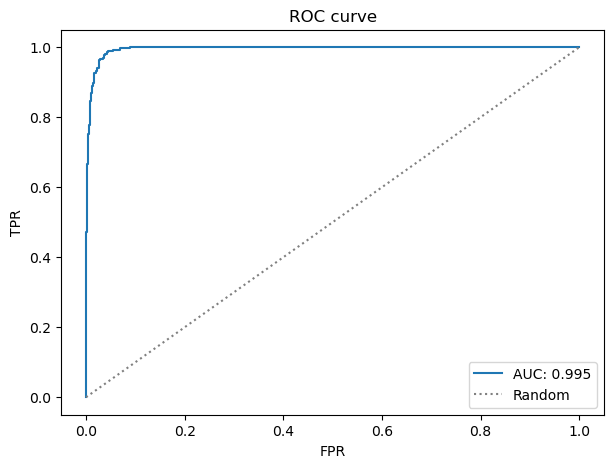

In [32]:
output = evaluation(model, input_x, input_y)